In [1]:
from pathlib import Path

arches = (
    "linux-64",
    "win-64",
    "osx-64",
    "noarch",
    "linux-ppc64le",
    "linux-aarch64",
)


def remove_existing(fname):
    if fname.is_file():
        fname.unlink()


# Clean old files first.
path = Path(".")
for arch in arches:
    remove_existing(path.joinpath(f"repodata-{arch}.json"))
    remove_existing(path.joinpath(f"repodata-cf201901-{arch}.json"))

In [2]:
import shutil

import requests


def download_file(url, fname):
    with requests.get(url, stream=True) as r:
        with open(fname, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    return fname

In [3]:
for arch in arches:
    download_file(
        f"https://conda.anaconda.org/conda-forge/{arch}/repodata.json",
        f"repodata-{arch}.json",
    )
    download_file(
        f"https://conda.anaconda.org/conda-forge/label/cf201901/{arch}/repodata.json",
        f"repodata-cf201901-{arch}.json",
    )

In [4]:
import gzip


def read_json(fname):
    with gzip.GzipFile(fname, "r") as f:
        return pd.io.json.loads(f.read())

In [5]:
import glob

import pandas as pd

packages = []
for fname in glob.glob("repodata-*.json"):
    data = read_json(fname)
    df = pd.DataFrame(data["packages"].values())
    df.loc[:, "filename"] = data["packages"].keys()
    packages.append(df)

In [6]:
df = pd.concat(packages, sort=False, ignore_index=True)

In [7]:
df = df.drop_duplicates(subset=["subdir", "filename"])

In [8]:
df.loc[:, "timestamp"] = pd.to_datetime(df.timestamp, unit="ms")

In [9]:
len(df)

257784

Almost 200 thousand artifacts.   Due to us only pulling from master packages that got deprecated during the compiler migration are excluded from
this analysis.

In [10]:
df.timestamp.isnull().sum()

97304

Around half of the packages do not have a creation timestamp in their metadata. thus we kinda have to ignore them

In [11]:
has_ts = df[df.timestamp.notnull()]
has_ts.head()

,timestamp,depends,arch,operatingsystem,target-triplet,size,build_number,name,license,has_prefix,...,app_entry,icon,summary,type,app_type,track_features,filename,sha256,app_own_environment,noarch
0,2018-08-23 11:22:44.664,"[certifi >=2016.09, python >=3.6,<3.7.0a0, win...",x86_64,win32,x86_64-any-win32,587281.0,0.0,setuptools,MIT,False,...,NaN,NaN,NaN,NaN,NaN,NaN,setuptools-40.2.0-py36_0.tar.bz2,NaN,NaN,NaN
3,2018-10-03 08:51:01.509,"[python >=3.7,<3.8.0a0, vc 14.*]",x86_64,win32,x86_64-any-win32,2861696.0,1000.0,cython,Apache-2.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,cython-0.28.5-py37h6538335_1000.tar.bz2,NaN,NaN,NaN
5,2018-10-07 03:07:40.147,"[curl >=7.59.0,<8.0a0, libssh2 >=1.8.0,<1.9.0a...",x86_64,win32,x86_64-any-win32,647983.0,0.0,libgit2,GPLv2 with Linking Exception,True,...,NaN,NaN,NaN,NaN,NaN,NaN,libgit2-0.27.5-hfac1375_0.tar.bz2,NaN,NaN,NaN
6,2018-11-16 22:12:12.220,"[numpy >=1.11.3,<2.0a0, python >=3.6,<3.7.0a0,...",x86_64,win32,x86_64-any-win32,446348.0,1004.0,spglib,BSD-3-clause,False,...,NaN,NaN,NaN,NaN,NaN,NaN,spglib-1.11.1-py36h452e1ab_1004.tar.bz2,NaN,NaN,NaN
11,2018-07-31 17:33:32.572,"[graphviz, python >=3.5,<3.6.0a0]",x86_64,win32,x86_64-any-win32,27310.0,2.0,python-graphviz,MIT,False,...,NaN,NaN,NaN,NaN,NaN,NaN,python-graphviz-0.8.4-py35_2.tar.bz2,NaN,NaN,NaN


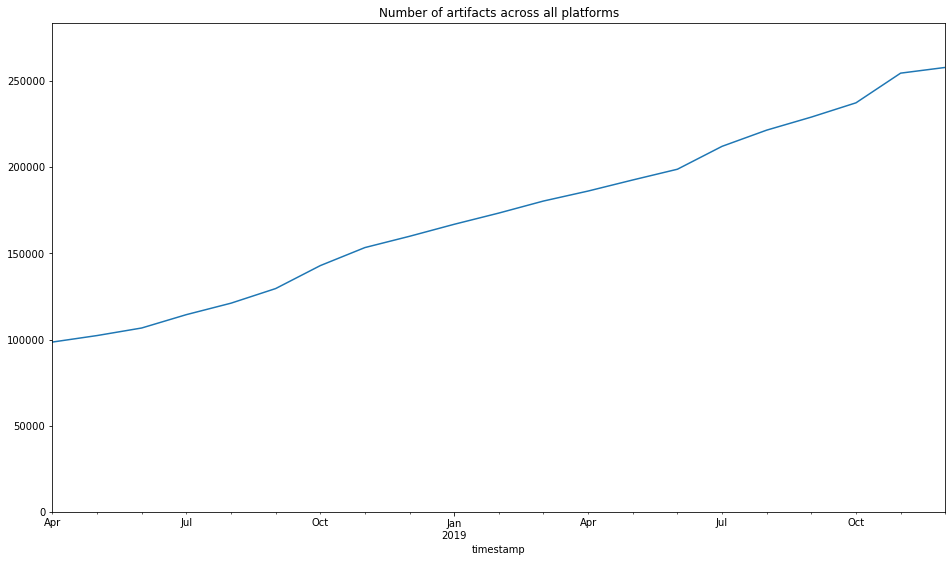

In [12]:
fill_val = "2018-03-01"
df_has = (
    df.fillna(pd.to_datetime(fill_val)).sort_values("timestamp").set_index("timestamp")
)
df_has.loc[:, "package_count"] = list(range(1, len(df_has) + 1))
df_arrival = df_has.groupby(df_has.index.to_period("M")).package_count.max()
df_arrival[df_arrival.index > fill_val].plot(
    title="Number of artifacts across all platforms",
    ylim=(0, df_arrival.max() * 1.1),
    figsize=(16, 9),
)

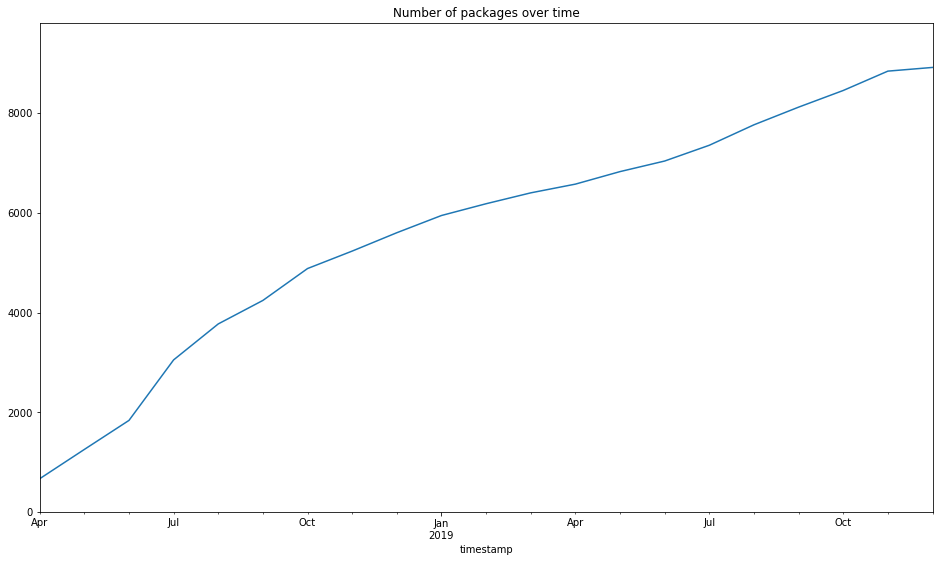

In [13]:
fill_val = "2018-03-01"
x = (
    df.sort_values("timestamp")
    .fillna(pd.to_datetime(fill_val))
    .groupby(df.name)
    .first()
)
first_date = pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
df_first = first_date.groupby(first_date.index.to_period("M")).package_count.max()
df_first[df_first.index > fill_val].plot(
    title="Number of packages over time",
    ylim=(0, df_first.max() * 1.1),
    figsize=(16, 9),
)

In [14]:
arch_df = {}
for arch in arches:
    fill_val = "2018-03-01"
    x = (
        df.sort_values("timestamp")
        .fillna(pd.to_datetime(fill_val))
        .loc[df.subdir == arch]
        .groupby(df.name)
        .first()
    )
    first_date = (
        pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
    )
    first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
    df_first = first_date.groupby(first_date.index.to_period("W")).package_count.max()
    arch_df[arch] = df_first

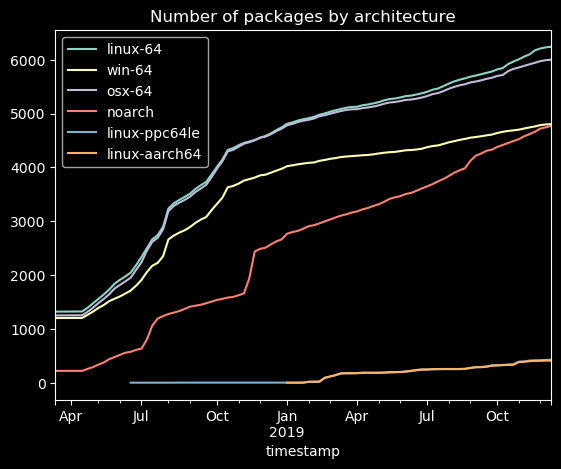

In [15]:
import matplotlib.pyplot as plt

with plt.style.context("dark_background", "seaborn-talk"):
    plot_df = pd.DataFrame(arch_df)
    plot_df.ffill()[plot_df.index > fill_val].plot(
        title="Number of packages by architecture",
    )